In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential, models, layers # type: ignore
from tensorflow.keras.applications import ResNet50, ResNet101,VGG16,VGG19,DenseNet201,DenseNet121,DenseNet169,ResNet152 # type: ignore
from tensorflow.keras.applications import ResNet152,ResNet50V2,ResNet101V2,Xception, InceptionV3, InceptionResNetV2, MobileNet,MobileNetV2 # type: ignore
from tensorflow.keras.applications import MobileNetV3Small,MobileNetV3Large,NASNetMobile,NASNetLarge, EfficientNetB0 # type: ignore
from tensorflow.keras.applications import EfficientNetB1,EfficientNetB7,ConvNeXtTiny,ConvNeXtSmall, ConvNeXtBase, ConvNeXtLarge # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import matplotlib.pyplot as plt

from tensorflow.keras.layers import MultiHeadAttention # type: ignore

In [2]:
print("TensorFlow version:", tf.__version__)
import sys
print("Python version:", sys.version)
import keras
print(keras.__version__)


TensorFlow version: 2.19.0
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
3.10.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = np.load('/content/drive/MyDrive/datasetWithoutCLAHE_TrainAndTest.npz')

train_images = data['train_images']
train_labels = data['train_labels']
# val_images = data['val_images']
# val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

print("Data loaded successfully!")


Data loaded successfully!


In [5]:

def resize_image(image):
    image = tf.image.resize(image, [224, 224]) # default input size for the model
    return image

def normalize_images(image):
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1] range
    return image

# Function to augment the image
def augment_image(image):

    image = tf.image.flip_left_right(image)
    image = tf.image.flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))   # Randomly rotate the image
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
    image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
    image = tf.image.random_crop(image, size=[256, 256, 3])

    # Clip the image to ensure values are in the range [0, 1]
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    return image

def load_and_preprocess_image(image, label, data_augmentation=True):

    image = normalize_images(image)

    if data_augmentation:
        image = augment_image(image)

    image = resize_image(image)# resize the image

    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices( (train_images , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_images , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

batch_size=32  # Specify your desired batch size here
classes=4

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=batch_size*100)  # Shuffle with buffer size

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



## **Image** Data Generator (Not used)

In [ ]:
# Desired target size
target_size = (224, 224)
bs=32
classes=4

# Resize training and testing images
train_images = tf.image.resize(train_images, target_size)
test_images = tf.image.resize(test_images, target_size)

In [ ]:
# Define the data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load the training and validation datasets
train_dataset = train_datagen.flow(
    train_images, train_labels,
    batch_size=bs,
    shuffle=True  # Shuffle training data

)

test_dataset = val_datagen.flow(
    test_images, test_labels,
    batch_size=bs
)

**End of Data Generator** ===============================

In [6]:
# Load DenseNet121 with pre-trained weights, exclude the top layers
base_model = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze the base model to prevent retraining
base_model.trainable = False

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Single Model

In [7]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation='softmax'))




In [ ]:
# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity)
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/DenseNet169/epoch_{epoch:02d}.weights.h5',  # Save file with epoch number
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

# Add callbacks to the fit method
callbacks = [early_stopping, model_checkpoint]


In [8]:
input_shape = (224, 224, 3)  # Modify as per your model's input dimensions
model.build(input_shape=(None, *input_shape))
# Assuming you have defined your model architecture as `model`
try:
    model.load_weights('/content/drive/MyDrive/epoch_50_AC0.9357_V0.9318.weights.h5')
except ValueError as e:
    print(f"Error loading weights: {e}")


In [9]:
from tensorflow.keras.optimizers import Adam,SGD # type: ignore

optimizer = Adam(learning_rate=0.00001)  # Try a lower value like 0.00001 or higher like 0.001

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Continue training for the remaining epochs
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    initial_epoch=1,  # Set this to the epoch number you finished on
    epochs=30,  # Continue for the total desired epochs
    callbacks=[model_checkpoint, early_stopping]
)



In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
#plt.savefig('C:/Users/PC_I/OneDrive/Desktop/accuracy_plot.png')  # Save the accuracy plot as a PNG file
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'], color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
#plt.savefig('C:/Users/PC_I/OneDrive/Desktop/loss_plot.png')  # Save the loss plot as a PNG file
plt.show()


In [ ]:
# model.save('C:/Users/PC_I/OneDrive/Desktop//epoch_17_AC0.9728_V0.9299ModelwithCompile.h5')
# model.save('C:/Users/PC_I/OneDrive/Desktop//epoch_17_AC0.9728_V0.9299ModelwithCompile.keras')
model.save('/content/drive/MyDrive/my_model.keras')

In [ ]:

# Path to the saved .h5 model
#model_path = '/content/drive/MyDrive/BestOverlapModelA9728V9299 (1).h5'
model_path = '/content/drive/MyDrive/epoch_44_AC0.9600_V0.9223.weights.h5'

# Load the model
model = tf.keras.models.load_model(model_path)

# Display the model summary
model.summary()


In [10]:
from tensorflow.keras.optimizers import Adam,SGD # type: ignore

optimizer = Adam(learning_rate=0.00001)  # Try a lower value like 0.00001 or higher like 0.001

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Validation Accuracy: {val_accuracy}")



Training Accuracy: 0.9677419066429138
Validation Accuracy: 0.9317535758018494


In [11]:
print(f"accuracy loss: {train_loss}")
print(f"Validation loss: {val_loss}")

accuracy loss: 0.1175461858510971
Validation loss: 0.2209583818912506


In [12]:
from keras.models import load_model
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Load your saved model
#model = tf.keras.models.load_model('/content/drive/MyDrive/lastOutcome.h5')

# Step 2: Recompile the model with the same settings
# model.compile(optimizer='SGD',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# Step 3: Define test dataset (if not already defined)
# Ensure test_dataset is properly loaded, for example:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_dataset = test_datagen.flow_from_directory('path_to_test_directory', ...)

# Step 4: Make predictions on the validation dataset
y_true = []
y_pred = []

# Iterate through the validation dataset and collect predictions and true labels
for images, labels in test_dataset:  # Assuming test_dataset is already batched
    predictions = model.predict(images)

    # Collect true labels (assumed to be integer-encoded)
    y_true.extend(labels.numpy())  # Convert TensorFlow tensor to numpy array

    # Collect predicted labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Step 5: Define class names
class_names = ['Cataract', 'Glaucoma', 'Normal', 'DR']

# Step 6: Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Step 7: Print Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [13]:
# Step 4: Calculate per-class accuracy from the confusion matrix
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for idx, accuracy in enumerate(per_class_accuracy):
    print(f"Accuracy for class {class_names[idx]}: {accuracy:.4f}")


Accuracy for class Cataract: 0.9382
Accuracy for class Glaucoma: 0.8413
Accuracy for class Normal: 0.9442
Accuracy for class DR: 0.9964


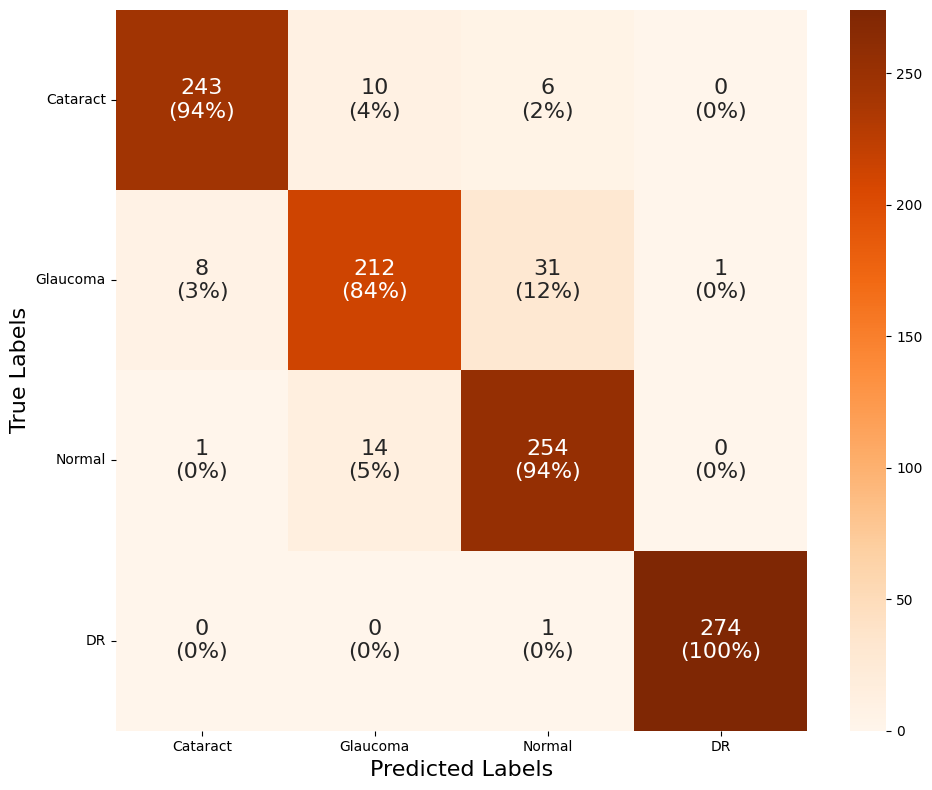

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a new matrix with both counts and percentages for annotations
annot_matrix = np.array([[f"{count}\n({percent:.0f}%)" for count, percent in zip(row, norm_row)]
                         for row, norm_row in zip(conf_matrix, normalized_conf_matrix)])


# Step 2: Create the plot
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=annot_matrix, fmt="", cmap='Oranges',
                 xticklabels=class_names, yticklabels=class_names, cbar=True,annot_kws={"size": 16})



# Add labels and title
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
#plt.title('Confusion Matrix (Sample Counts & Percentage)', fontsize=16)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 645ms/step


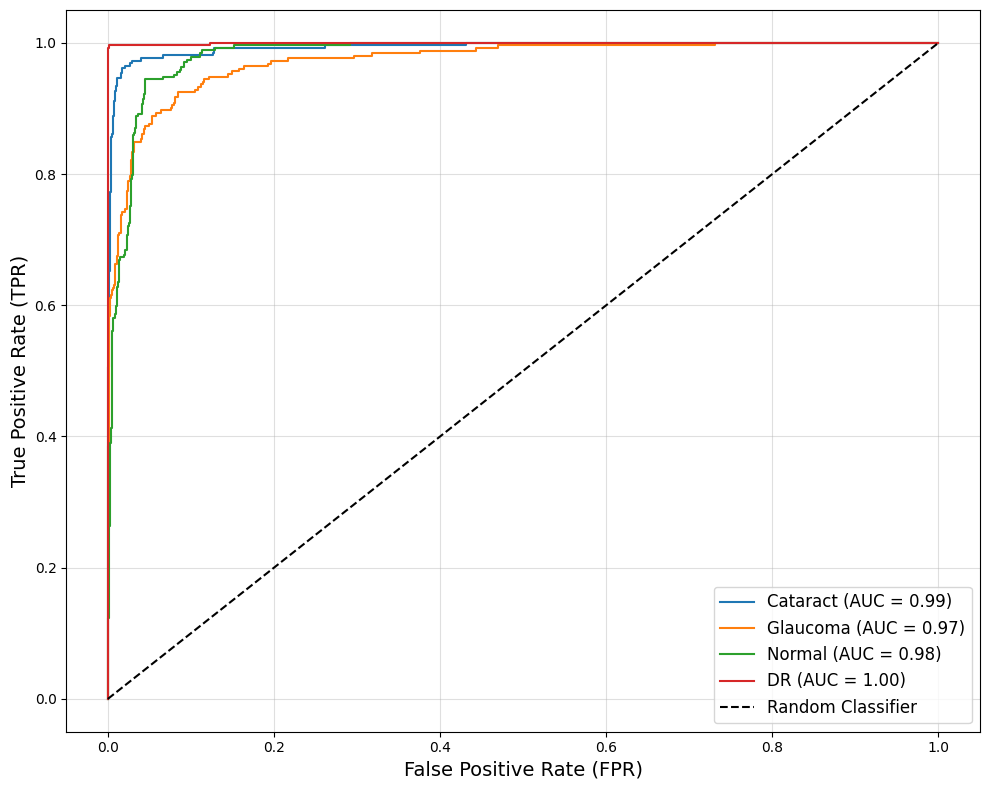

Macro-Averaged AUC: 0.9871
Weighted-Averaged AUC: 0.9873


In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get the true labels and predicted probabilities
y_prob = model.predict(test_dataset)  # Predicted probabilities
y_true = []  # True labels

# Collect true labels from the test dataset
for _, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Step 2: Calculate AUC for each class and store it
roc_aucs = []
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    # Binary relevance for class i
    fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

    # Plot ROC curve for the class
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Step 3: Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

# Step 4: Add labels, title, and legend
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
#plt.title("ROC Curve - MultiClass Classification", fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Step 5: Calculate Final AUC Metrics
macro_avg_auc = np.mean(roc_aucs)  # Macro-averaged AUC
weights = [np.sum(y_true == i) for i in range(len(class_names))]
weighted_avg_auc = np.average(roc_aucs, weights=weights)  # Weighted-averaged AUC

print(f"Macro-Averaged AUC: {macro_avg_auc:.4f}")
print(f"Weighted-Averaged AUC: {weighted_avg_auc:.4f}")


In [16]:
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np

# Step 4: Collect all predictions and true labels
y_true = []
y_pred = []
y_prob = []  # To store probabilities for AUC

# Iterate through the validation dataset and collect predictions and true labels
for images, labels in test_dataset:  # Assuming test_dataset is already batched
    predictions = model.predict(images)

    # Collect true labels (assumed to be integer-encoded)
    y_true.extend(labels.numpy())  # Convert TensorFlow tensor to numpy array

    # Collect predicted labels and probabilities
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels
    y_prob.extend(predictions)  # Store the raw probabilities for AUC

# Convert to numpy arrays for easier handling
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Step 5: Calculate AUC for each class
auc_scores = {}
for i, class_name in enumerate(class_names):
    auc = roc_auc_score(y_true == i, y_prob[:, i])
    auc_scores[class_name] = auc

# Step 6: Get the classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract precision, recall, and f1 score from the classification report

metrics = {
    'class': class_names,
    'precision': [report_dict[class_name]['precision'] for class_name in class_names],
    'recall': [report_dict[class_name]['recall'] for class_name in class_names],
    'f1-score': [report_dict[class_name]['f1-score'] for class_name in class_names],
    'AUC': [auc_scores[class_name] for class_name in class_names]
}

# Convert to DataFrame for better formatting
df_metrics = pd.DataFrame(metrics)

# Display the table
print(df_metrics)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 